### 32x32 CNN with random input

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
class CNN(layers.Layer):
    def __init__(self, units, kernel_size, strides, padding):
        super(CNN, self).__init__()
        self.cnn = layers.Conv2D(filters=units, kernel_size=kernel_size, strides=strides, padding=padding)
        self.bn = layers.BatchNormalization()
    
    def call(self, x, training=False):
        x = self.cnn(x)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        return x

In [3]:
class model32(keras.Model):
    def __init__(self):
        super(model32, self).__init__()
        self.layer1 = CNN(units=64, kernel_size=2, strides=1, padding='same')
        self.layer2 = layers.MaxPool2D(pool_size=(2, 2))
        self.layer3 = layers.Dropout(rate=0.3)
        self.layer4 = CNN(units=40, kernel_size=3, strides=1, padding='same')
        self.layer5 = layers.MaxPool2D(pool_size=(2, 2))
        self.layer6 = CNN(units=30, kernel_size=3, strides=1, padding='same')
        self.layer7 = layers.MaxPool2D(pool_size=(2, 2))
        self.layer8 = CNN(units=25, kernel_size=3, strides=1, padding='same')
        self.layer9 = layers.MaxPool2D(pool_size=(2, 2))
        self.flatten = layers.Flatten()
        self.layer10 = layers.Dense(units=512, activation='sigmoid')
        self.layer11 = layers.Dropout(rate=0.3)
        self.layer12 = layers.Dense(units=1, activation='sigmoid')
    
    def call(self, x, training=False):
        x = self.layer1(x, training=training)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x, training=training)
        x = self.layer5(x)
        x = self.layer6(x, training=training)
        x = self.layer7(x)
        x = self.layer8(x, training=training)
        x = self.layer9(x)
        x = self.flatten(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        return x

    def model(self):
        x = keras.Input(shape=(32, 32, 3))
        return keras.Model(inputs=[x], outputs=[self.call(x)])

In [4]:
model = model32()
model.model().summary()

Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cnn (CNN)                   (None, 32, 32, 64)        1088      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 cnn_1 (CNN)                 (None, 16, 16, 40)        23240     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 40)         0         
 2D)                           

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    shear_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=0.3,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1/255.
)

In [6]:
train_dataset = train_datagen.flow_from_directory(
    directory='../../data/train/',
    target_size=(32, 32),
    class_mode='binary',
    batch_size=32,
    subset='training'
)

val_dataset = train_datagen.flow_from_directory(
    directory='../../data/train/',
    target_size=(32, 32),
    class_mode='binary',
    batch_size=32,
    subset='validation'
)

test_dataset = test_datagen.flow_from_directory(
    directory='../../data/test/',
    target_size=(32, 32),
    class_mode='binary'
)

Found 2374 images belonging to 2 classes.
Found 263 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [7]:
model = model32()
model.compile(optimizer=tf.keras.optimizers.Adagrad(), loss='binary_crossentropy', 
             metrics=[
                 tf.keras.metrics.AUC(),
                 tf.keras.metrics.FalseNegatives(),
                 tf.keras.metrics.FalsePositives(),
                 tf.keras.metrics.Precision(),
                 tf.keras.metrics.Recall(),
                 'accuracy'
             ])
history = model.fit(train_dataset, 
                    epochs=100, 
                    validation_data=val_dataset, 
                    steps_per_epoch=len(train_dataset),
                    validation_steps=len(val_dataset))

Epoch 1/100
75/75 [==============================] - 8s 72ms/step - loss: 0.6674 - auc: 0.6354 - false_negatives: 477.0000 - false_positives: 462.0000 - precision: 0.5654 - recall: 0.5575 - accuracy: 0.6045 - val_loss: 0.6928 - val_auc: 0.5988 - val_false_negatives: 119.0000 - val_false_positives: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.5475
Epoch 2/100
75/75 [==============================] - 3s 39ms/step - loss: 0.5740 - auc: 0.7930 - false_negatives: 376.0000 - false_positives: 287.0000 - precision: 0.7098 - recall: 0.6512 - accuracy: 0.7207 - val_loss: 0.7063 - val_auc: 0.7647 - val_false_negatives: 119.0000 - val_false_positives: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.5475
Epoch 3/100
75/75 [==============================] - 3s 39ms/step - loss: 0.5286 - auc: 0.8426 - false_negatives: 323.0000 - false_positives: 244.0000 - precision: 0.7558 - recall: 0.7004 - accuracy: 0.7612 - val_loss: 0.6950 - 

Epoch 23/100
75/75 [==============================] - 3s 40ms/step - loss: 0.3992 - auc: 0.8984 - false_negatives: 200.0000 - false_positives: 262.0000 - precision: 0.7702 - recall: 0.8145 - accuracy: 0.8054 - val_loss: 0.5875 - val_auc: 0.8702 - val_false_negatives: 82.0000 - val_false_positives: 9.0000 - val_precision: 0.8043 - val_recall: 0.3109 - val_accuracy: 0.6540
Epoch 24/100
75/75 [==============================] - 3s 40ms/step - loss: 0.3988 - auc: 0.8981 - false_negatives: 194.0000 - false_positives: 252.0000 - precision: 0.7782 - recall: 0.8200 - accuracy: 0.8121 - val_loss: 0.5669 - val_auc: 0.8733 - val_false_negatives: 80.0000 - val_false_positives: 7.0000 - val_precision: 0.8478 - val_recall: 0.3277 - val_accuracy: 0.6692
Epoch 25/100
75/75 [==============================] - 3s 39ms/step - loss: 0.3966 - auc: 0.8976 - false_negatives: 181.0000 - false_positives: 260.0000 - precision: 0.7753 - recall: 0.8321 - accuracy: 0.8142 - val_loss: 0.5778 - val_auc: 0.8708 - val_f

Epoch 45/100
75/75 [==============================] - 3s 40ms/step - loss: 0.3796 - auc: 0.9062 - false_negatives: 175.0000 - false_positives: 258.0000 - precision: 0.7778 - recall: 0.8377 - accuracy: 0.8176 - val_loss: 0.5743 - val_auc: 0.8797 - val_false_negatives: 76.0000 - val_false_positives: 8.0000 - val_precision: 0.8431 - val_recall: 0.3613 - val_accuracy: 0.6806
Epoch 46/100
75/75 [==============================] - 3s 40ms/step - loss: 0.3815 - auc: 0.9047 - false_negatives: 168.0000 - false_positives: 258.0000 - precision: 0.7791 - recall: 0.8442 - accuracy: 0.8206 - val_loss: 0.5822 - val_auc: 0.8828 - val_false_negatives: 82.0000 - val_false_positives: 8.0000 - val_precision: 0.8222 - val_recall: 0.3109 - val_accuracy: 0.6578
Epoch 47/100
75/75 [==============================] - 3s 40ms/step - loss: 0.3775 - auc: 0.9062 - false_negatives: 172.0000 - false_positives: 257.0000 - precision: 0.7790 - recall: 0.8404 - accuracy: 0.8193 - val_loss: 0.5903 - val_auc: 0.8828 - val_f

Epoch 67/100
75/75 [==============================] - 3s 40ms/step - loss: 0.3666 - auc: 0.9123 - false_negatives: 163.0000 - false_positives: 236.0000 - precision: 0.7950 - recall: 0.8488 - accuracy: 0.8319 - val_loss: 0.5756 - val_auc: 0.8814 - val_false_negatives: 75.0000 - val_false_positives: 7.0000 - val_precision: 0.8627 - val_recall: 0.3697 - val_accuracy: 0.6882
Epoch 68/100
75/75 [==============================] - 3s 40ms/step - loss: 0.3659 - auc: 0.9127 - false_negatives: 167.0000 - false_positives: 238.0000 - precision: 0.7929 - recall: 0.8451 - accuracy: 0.8294 - val_loss: 0.5979 - val_auc: 0.8842 - val_false_negatives: 80.0000 - val_false_positives: 5.0000 - val_precision: 0.8864 - val_recall: 0.3277 - val_accuracy: 0.6768
Epoch 69/100
75/75 [==============================] - 3s 40ms/step - loss: 0.3723 - auc: 0.9097 - false_negatives: 174.0000 - false_positives: 255.0000 - precision: 0.7800 - recall: 0.8386 - accuracy: 0.8193 - val_loss: 0.5990 - val_auc: 0.8874 - val_f

Epoch 89/100
75/75 [==============================] - 3s 40ms/step - loss: 0.3541 - auc: 0.9178 - false_negatives: 147.0000 - false_positives: 252.0000 - precision: 0.7870 - recall: 0.8636 - accuracy: 0.8319 - val_loss: 0.5974 - val_auc: 0.8875 - val_false_negatives: 77.0000 - val_false_positives: 4.0000 - val_precision: 0.9130 - val_recall: 0.3529 - val_accuracy: 0.6920
Epoch 90/100
75/75 [==============================] - 3s 40ms/step - loss: 0.3496 - auc: 0.9205 - false_negatives: 153.0000 - false_positives: 229.0000 - precision: 0.8016 - recall: 0.8581 - accuracy: 0.8391 - val_loss: 0.5825 - val_auc: 0.8902 - val_false_negatives: 76.0000 - val_false_positives: 4.0000 - val_precision: 0.9149 - val_recall: 0.3613 - val_accuracy: 0.6958
Epoch 91/100
75/75 [==============================] - 3s 40ms/step - loss: 0.3506 - auc: 0.9191 - false_negatives: 144.0000 - false_positives: 249.0000 - precision: 0.7895 - recall: 0.8664 - accuracy: 0.8345 - val_loss: 0.5753 - val_auc: 0.8925 - val_f

In [8]:
history.history.keys()

dict_keys(['loss', 'auc', 'false_negatives', 'false_positives', 'precision', 'recall', 'accuracy', 'val_loss', 'val_auc', 'val_false_negatives', 'val_false_positives', 'val_precision', 'val_recall', 'val_accuracy'])

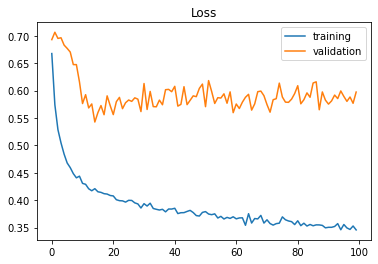

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend();

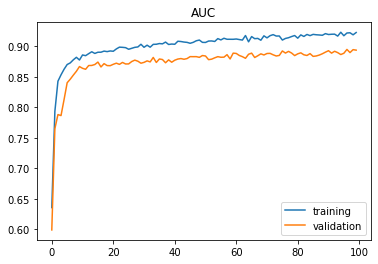

In [10]:
plt.figure()
plt.plot(history.history['auc'], label='training')
plt.plot(history.history['val_auc'], label='validation')
plt.title('AUC')
plt.legend();

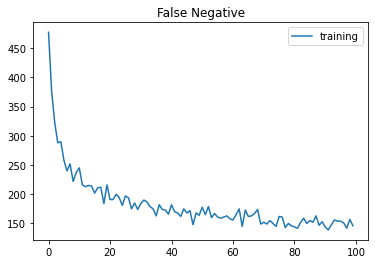

In [11]:
plt.figure()
plt.plot(history.history['false_negatives'], label='training')
plt.title('False Negative')
plt.legend();

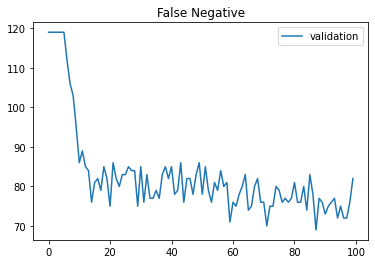

In [12]:
plt.figure()
plt.plot(history.history['val_false_negatives'], label='validation')
plt.title('False Negative')
plt.legend();

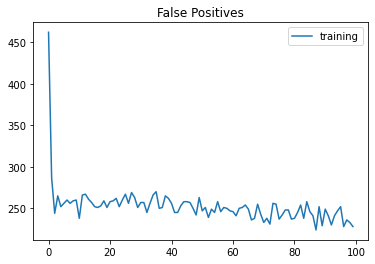

In [13]:
plt.figure()
plt.plot(history.history['false_positives'], label='training')
plt.title('False Positives')
plt.legend();

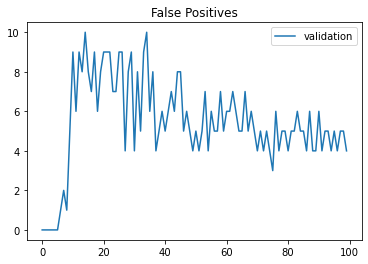

In [14]:
plt.figure()
plt.plot(history.history['val_false_positives'], label='validation')
plt.title('False Positives')
plt.legend();

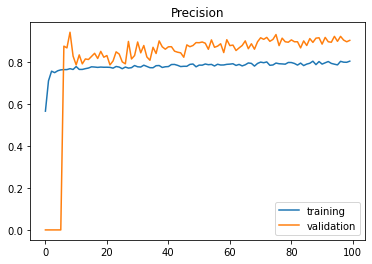

In [15]:
plt.figure()
plt.plot(history.history['precision'], label='training')
plt.plot(history.history['val_precision'], label='validation')
plt.title('Precision')
plt.legend();

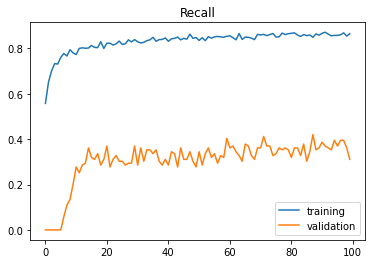

In [16]:
plt.figure()
plt.plot(history.history['recall'], label='training')
plt.plot(history.history['val_recall'], label='validation')
plt.title('Recall')
plt.legend();

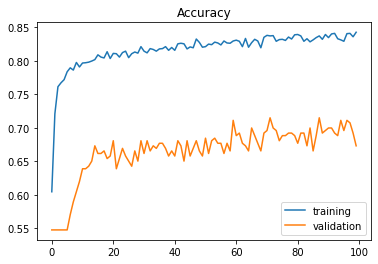

In [17]:
plt.figure()
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend();

In [18]:
model.evaluate(train_dataset)

75/75 [==============================] - 3s 35ms/step - loss: 0.4670 - auc: 0.9205 - false_negatives: 516.0000 - false_positives: 65.0000 - precision: 0.8963 - recall: 0.5213 - accuracy: 0.7553


[0.4670059084892273,
 0.9204818606376648,
 516.0,
 65.0,
 0.8963317275047302,
 0.5213358402252197,
 0.7552654147148132]

In [19]:
model.evaluate(val_dataset)

9/9 [==============================] - 0s 34ms/step - loss: 0.6095 - auc: 0.8869 - false_negatives: 79.0000 - false_positives: 5.0000 - precision: 0.8889 - recall: 0.3361 - accuracy: 0.6806


[0.6094912886619568,
 0.886875569820404,
 79.0,
 5.0,
 0.8888888955116272,
 0.3361344635486603,
 0.680608332157135]

In [20]:
model.evaluate(test_dataset)

21/21 [==============================] - 1s 44ms/step - loss: 0.4665 - auc: 0.9121 - false_negatives: 140.0000 - false_positives: 20.0000 - precision: 0.8889 - recall: 0.5333 - accuracy: 0.7576


[0.46654874086380005,
 0.9121388792991638,
 140.0,
 20.0,
 0.8888888955116272,
 0.5333333611488342,
 0.7575758099555969]